In [1]:
from imports import cv2, os, np, tf, ImageDataGenerator, plt, pd, requests
import confidential

firebase_url = confidential.get_url()

response = requests.get(firebase_url)

data = response.json()
data_list = [value for key, value in data.items()]

df = pd.DataFrame(data_list)
df = df[["name", "url"]]

def download_image(url, name):
    """
    Downloads the images from database

    Args:
        url: url of the image

    Returns:
        image: image in grayscale
    """
    response = requests.get(url)
    image_data = response.content
    array = bytearray(image_data)

    image = cv2.imdecode(np.asarray(array, dtype=np.uint8), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (160, 160))
    return image

images = []

for index, row in df.iterrows():
    image = download_image(row["url"], row["name"])
    images.append(image)

images = np.array(images)

2024-05-05 23:29:11.819188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 23:29:11.819281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 23:29:11.821246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 23:29:11.829450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 23:29:12.599975: W tensorflow/compiler/tf2

In [2]:
print(images.shape)

(4, 160, 160)


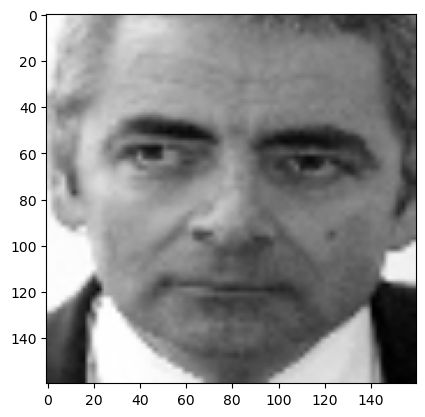

In [3]:
def crop_face(image):
    """
    Crops the face from input image using Haar Cascade Classifier

    Args:
        image: image

    Returns:
        face: face image
    """
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(image, 1.1, 4)
    if len(faces) == 0:
        return None
    for (x, y, w, h) in faces:
        face = cv2.resize(image[y:y+h, x:x+w], (160, 160))
    return face

faces = []

for image in images:
    face = crop_face(image)
    if face is not None:
        faces.append(face)

faces = np.array(faces)

plt.imshow(faces[0], cmap="gray")

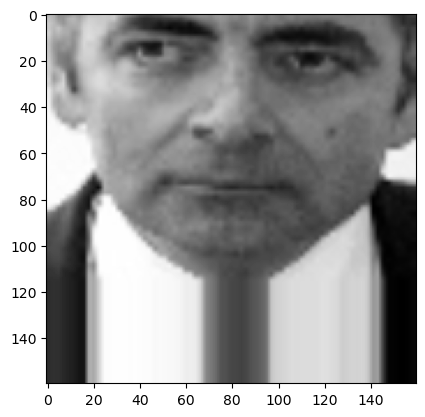

In [4]:
precision = 50

def augment_images(images):
    """
    Augment images using ImageDataGenerator

    Args:
        images (numpy.ndarray): Images to augment
    
    Returns:
        numpy.ndarray: Augmented images
    """
    train_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.1,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        vertical_flip=True,
                                        fill_mode='nearest'
                                        )
    augmented_images = []
    for image in images:
        image = np.expand_dims(image, 0)
        i = 0
        for i in range(precision):
            augmented_images.append(train_datagen.random_transform(image))
            i += 1
            if i >= precision:
                break
    return augmented_images

augmented_images = augment_images(faces)
augmented_images = np.array(augmented_images).reshape(-1, 160, 160)
plt.imshow(augmented_images[2], cmap='gray')

In [5]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=50)
lfw_images = lfw_people.images
lwf_target_names = lfw_people.target_names
lwf_labels = lfw_people.target

In [6]:
lfw_images = [cv2.resize(image, (160, 160)) for image in lfw_images]
lfw_images = np.array(lfw_images)
lwf_labels = np.array(lwf_labels)

In [7]:
names = df["name"].values
labels = np.arange(len(names))
labels += len(lwf_target_names)
labels = np.repeat(labels, precision)
names = np.append(lwf_target_names, names)
labels = np.append(lwf_labels, labels)
images = np.append(lfw_images, augmented_images, axis=0)

In [8]:
classes = len(names)

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=69)

In [15]:
from keras.optimizers import Adam
class model_init:
    def __init__(self, classes, input_shape, num_dense_layers, num_dense_units, num_conv_layers, filters, kernel_size, pool_size, dropout_rate):
        """
        Initialize the model with the given parameters
        """
        self.classes = classes
        self.input_shape = input_shape
        self.num_dense_layers = num_dense_layers
        self.num_dense_units = num_dense_units
        self.num_conv_layers = num_conv_layers
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout_rate = dropout_rate

        self.model = self.build_model()

    def conv_block(self, input, filters, kernel_size, pool_size):
        """
        Convolutional block with Conv2D, Activation and MaxPooling2D layers
        """
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding="valid", activation="elu")(input)
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding="valid", activation="elu")(x)
        x = tf.keras.layers.Conv2D(2*filters, kernel_size, padding="valid", activation="elu")(x)
        x = tf.keras.layers.MaxPooling2D(pool_size)(x)
        return x
    
    def dense_block(self, input, units, dropout):
        """
        Dense block with Dense, Activation and Dropout layers
        """
        x = tf.keras.layers.Dense(units, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(input)
        x = tf.keras.layers.Dropout(dropout)(x)
        return x
    
    def build_model(self):
        """
        Build the model with the given parameters
        """
        input = tf.keras.layers.Input(shape=self.input_shape)

        x = self.conv_block(input, self.filters, self.kernel_size, self.pool_size)
        for i in range(self.num_conv_layers - 1):
            x = self.conv_block(x, self.filters, self.kernel_size, self.pool_size)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("elu")(x)
        x = tf.keras.layers.Dropout(self.dropout_rate)(x)

        x = self.conv_block(input, self.filters, self.kernel_size, self.pool_size)
        for i in range(self.num_conv_layers - 1):
            x = self.conv_block(x, self.filters, self.kernel_size, self.pool_size)

        x = tf.keras.layers.Flatten()(x)
        
        for i in range(self.num_dense_layers):
            x = self.dense_block(x, self.num_dense_units, self.dropout_rate)
        output = tf.keras.layers.Dense(self.classes, activation="softmax")(x)
        model = tf.keras.Model(inputs=input, outputs=output)
        return model
    


model = model_init(classes, input_shape=(160, 160, 1), num_dense_layers=2, num_dense_units=256, num_conv=2, filters=64, kernel_size=(3, 3), pool_size=(3, 3), dropout_rate=0.6)

model = model.build_model()

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/150


2024-05-05 23:38:57.431476: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-05 23:38:57.655265: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


88/88 [==============================] - 10s 49ms/step - loss: 11.8654 - accuracy: 0.1946 - val_loss: 9.7863 - val_accuracy: 0.3750
Epoch 2/150
88/88 [==============================] - 4s 42ms/step - loss: 10.7219 - accuracy: 0.2294 - val_loss: 9.3748 - val_accuracy: 0.3608
Epoch 3/150
88/88 [==============================] - 4s 42ms/step - loss: 9.1077 - accuracy: 0.2898 - val_loss: 8.8424 - val_accuracy: 0.4034
Epoch 4/150
88/88 [==============================] - 4s 42ms/step - loss: 7.8573 - accuracy: 0.3544 - val_loss: 6.9526 - val_accuracy: 0.4233
Epoch 5/150
88/88 [==============================] - 4s 42ms/step - loss: 6.5485 - accuracy: 0.4226 - val_loss: 5.5165 - val_accuracy: 0.5625
Epoch 6/150
88/88 [==============================] - 4s 42ms/step - loss: 5.7499 - accuracy: 0.4645 - val_loss: 4.8722 - val_accuracy: 0.6307
Epoch 7/150
88/88 [==============================] - 4s 42ms/step - loss: 5.1850 - accuracy: 0.5568 - val_loss: 4.4312 - val_accuracy: 0.6591
Epoch 8/150
88/

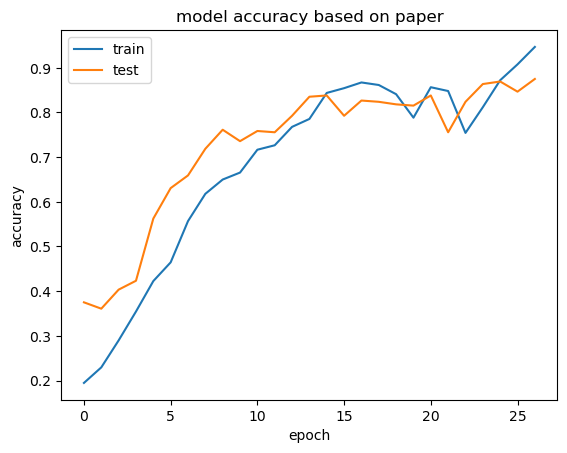

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy based on paper')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

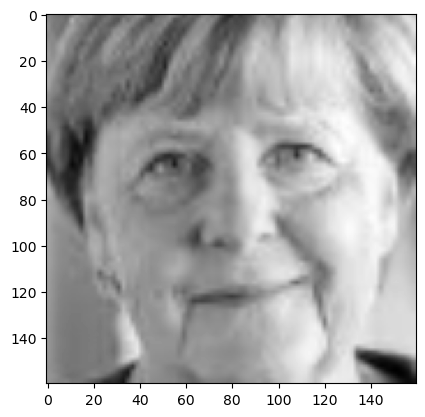

In [12]:
test_image = cv2.imread("test5.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = cv2.resize(test_image, (160, 160))
test_image = crop_face(test_image)
plt.imshow(test_image, cmap='gray')
test_image = np.expand_dims(test_image, 0)

In [13]:
prediction = model.predict(test_image)
print(prediction)

def get_name(prediction):
    if np.max(prediction) < 0.65:
        return "Unknown", 0
    idx = np.argmax(prediction)
    name = names[idx]
    return name, np.max(prediction)

name, p = get_name(prediction)
print(name, p)

1/1 [==============================] - 0s 314ms/step
[[4.31130815e-04 3.18990136e-03 4.09961725e-03 4.31241661e-01
  1.23206405e-02 5.55689214e-04 7.55655160e-03 3.01630516e-03
  2.58627697e-03 3.78373981e-04 7.08724037e-02 4.18299111e-03
  4.80688977e-05 3.20981024e-04 4.58199739e-01 9.99695505e-04]]
Unknown 0
